In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import random

# seed
random.seed(113)
torch.manual_seed(113)
torch.cuda.manual_seed(113)
np.random.seed(113)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Load the Dataset

In [2]:
train_dir = "train/"
test_dir = "test/"

In [3]:
train_transform = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.RandomRotation(5), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


test_transform = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_img = datasets.ImageFolder(train_dir, transform=train_transform)
test_img = datasets.ImageFolder(test_dir, transform=test_transform)

# Explore the Data

In [4]:
print("train_img type   :",type(train_img))
print("train_img length :",len(train_img))
print("test_img length :",len(test_img))
print("train_img classes:",train_img.classes)
print("train_img[0] type:",type(train_img[0]))
print("train_img[0][0] t:",type(train_img[0][0]))
print("train_img[0][1] t:",type(train_img[0][1]))
print("train_img[0][0] s:",train_img[0][0].size())
print("train_img[0][1]  :",train_img[0][1])

train_img type   : <class 'torchvision.datasets.folder.ImageFolder'>
train_img length : 940
test_img length : 120
train_img classes: ['JUICE', 'MILK', 'SODA', 'VINEGAR', 'WATER']
train_img[0] type: <class 'tuple'>
train_img[0][0] t: <class 'torch.Tensor'>
train_img[0][1] t: <class 'int'>
train_img[0][0] s: torch.Size([3, 150, 150])
train_img[0][1]  : 0


In [5]:
def imshow(data_image, tensor=False):
    image = data_image[0]
    label = data_image[1]
    image = image.numpy().transpose((1, 2, 0))

    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5],)
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.show()
    
    print(train_img.classes[label])

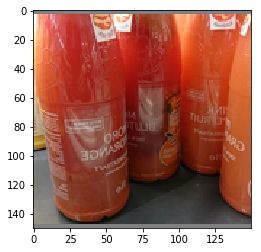

JUICE


In [6]:
imshow(train_img[0])

# Create the Loader

In [7]:
trainloaders = torch.utils.data.DataLoader(train_img, batch_size=64, shuffle=True)
testloaders = torch.utils.data.DataLoader(test_img, batch_size=32, shuffle=True)

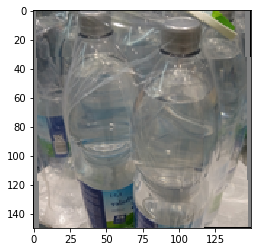

WATER


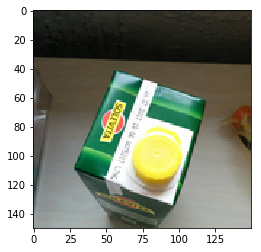

JUICE


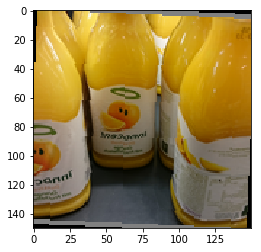

JUICE


In [8]:
for image, label in trainloaders:
    for i in range(3):
        imshow((image[i], label[i]))
    break

# Create the Architecture

there are two styles to create a model, using `class` or using `sequential`. I suggest to use `sequential` only for a simple model, or for a simple part of the class. In the example below, you can see three different ways to create a model.

please also remember this formula to calculate the size of feature after convolution:

$$\frac{(FEATURE - KERNEL + 2*PADDING)}{STRIDE} +1$$

In [15]:
########################
# Model using Class
#######################

class Net(nn.Module):
   
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(39200, 512)
        self.fc2 = nn.Linear(512, 5)
        self.do = nn.Dropout()
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.do(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=39200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (do): Dropout(p=0.5)
)

In [16]:
########################
# Model using Sequential
#######################

class Flatten(nn.Module):
    
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return x
    
model = torch.nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=0),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                        Flatten(),
                        nn.Linear(39200, 512),
                        nn.ReLU(),
                        nn.Dropout(),
                        nn.Linear(512, 5))

model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=39200, out_features=512, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.5)
  (10): Linear(in_features=512, out_features=5, bias=True)
)

In [17]:
########################
# Model using Sequential in Class
#######################

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = torch.nn.Sequential(
                            nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=0),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        self.classifier = torch.nn.Sequential(
                            nn.Linear(39200, 512),
                            nn.ReLU(),
                            nn.Dropout(),
                            nn.Linear(512, 5))
    
    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
model = Net()
model.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=512, out_features=5, bias=True)
  )
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epoch = 20

In [11]:
model.train()

for i in range(epoch):
    total_loss = 0
    total_sample = 0    
    total_correct = 0
    
    for image, label in trainloaders:
        image = image.to(device)
        label = label.to(device)
        
        out = model(image)
        
        loss = criterion(out, label)
        total_loss += loss.item()
        total_sample += len(label)
        total_correct += torch.sum(torch.max(out,1)[1]==label).item()*1.0
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch", i, total_loss/total_sample, total_correct/total_sample)

epoch 0 0.03751938647412239 0.3351063829787234
epoch 1 0.020481982763777388 0.4797872340425532
epoch 2 0.018205865646930452 0.5329787234042553
epoch 3 0.016982563759418243 0.5776595744680851
epoch 4 0.016117896805418298 0.5968085106382979
epoch 5 0.01503367005510533 0.6329787234042553
epoch 6 0.014015343468239967 0.6638297872340425
epoch 7 0.012732642571976845 0.701063829787234
epoch 8 0.01135281390966253 0.7457446808510638
epoch 9 0.010249291962765633 0.7574468085106383
epoch 10 0.009551758017945796 0.7797872340425532
epoch 11 0.008466217270556917 0.8095744680851064
epoch 12 0.007646689992001716 0.8265957446808511
epoch 13 0.006636699875618549 0.8457446808510638
epoch 14 0.006074706829608755 0.8617021276595744
epoch 15 0.005804869897188024 0.8680851063829788
epoch 16 0.005430242815550337 0.8765957446808511
epoch 17 0.004630008244768102 0.9
epoch 18 0.0037648141384124755 0.9202127659574468
epoch 19 0.003560575208765395 0.924468085106383


In [12]:
model.eval()
total_loss = 0
total_sample = 0    
total_correct = 0

for image, label in testloaders:
    image = image.to(device)
    label = label.to(device)
    
    out = model(image)

    loss = criterion(out, label)
    total_loss += loss.item()
    total_sample += len(label)
    total_correct += torch.sum(torch.max(out, 1)[1] == label).item()*1.0


print("test loss", total_loss/total_sample)
print("test accuracy", total_correct/total_sample)

test loss 0.025711530447006227
test accuracy 0.75


# Sanity Check

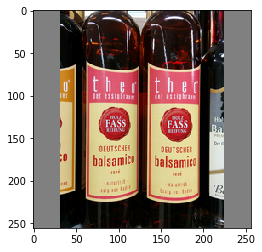

In [13]:
imagepath = "VINEGAR0139.png"
image_test = Image.open(imagepath)
plt.imshow(image_test)
plt.show()

In [14]:
image_transformed = test_transform(image_test) 
image_transformed = image_transformed.unsqueeze(0).to(device)
out = model(image_transformed)
print(out)
print("PREDICTION:", train_img.classes[torch.max(out,1)[1]])

tensor([[ 0.6045, -2.7093, -1.4815,  8.0160, -3.0436]], device='cuda:0',
       grad_fn=<AddmmBackward>)
PREDICTION: VINEGAR
